<a href="https://colab.research.google.com/github/Abdul-Khalek-Alve/Deep-Unsupervised-Fashion-Image-Clustering-Using-Siamese-Networks-and-Gaussian-Mixture-Models/blob/master/CSE425_Project_Deep_Unsupervised_clustering_with_FashionMNIST_Dataset_from_Hugging_Face_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the dataset
dataset = load_dataset("zalando-datasets/fashion_mnist")

# 2. Explore dataset structure
print(dataset)  # info on splits and features


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [4]:
# 3. Extract train and test splits
train_data = dataset['train']
test_data = dataset['test']

# 4. Check class names (labels)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 60000
Number of test samples: 10000


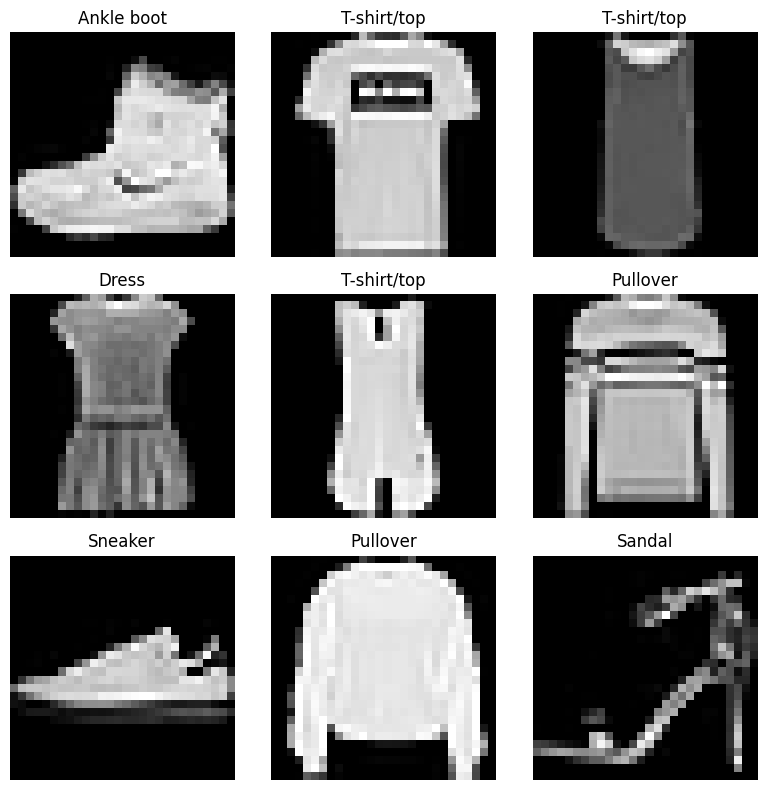

In [5]:
# 5. Visualize some samples from the dataset with labels
def show_samples(data, class_names, num_samples=9):
    plt.figure(figsize=(8,8))
    for i in range(num_samples):
        image = data[i]['image']  # PIL Image
        label = data[i]['label']
        plt.subplot(3, 3, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_data, class_names)

In [6]:
# 6. Convert entire dataset images to numpy arrays for analysis (optional)
def dataset_to_numpy(ds):
    images = np.array([np.array(sample['image']) for sample in ds])
    labels = np.array(ds['label'])
    return images, labels

train_images, train_labels = dataset_to_numpy(train_data)
test_images, test_labels = dataset_to_numpy(test_data)

print(f"Train images shape: {train_images.shape}")  # e.g. (60000, 28, 28)
print(f"Train labels shape: {train_labels.shape}")

# 7. Basic statistics
print(f"Pixel intensity range: {train_images.min()} to {train_images.max()}")
print(f"Unique labels and counts:")
(unique, counts) = np.unique(train_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {class_names[label]}: {count} samples")



Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Pixel intensity range: 0 to 255
Unique labels and counts:
  T-shirt/top: 6000 samples
  Trouser: 6000 samples
  Pullover: 6000 samples
  Dress: 6000 samples
  Coat: 6000 samples
  Sandal: 6000 samples
  Shirt: 6000 samples
  Sneaker: 6000 samples
  Bag: 6000 samples
  Ankle boot: 6000 samples


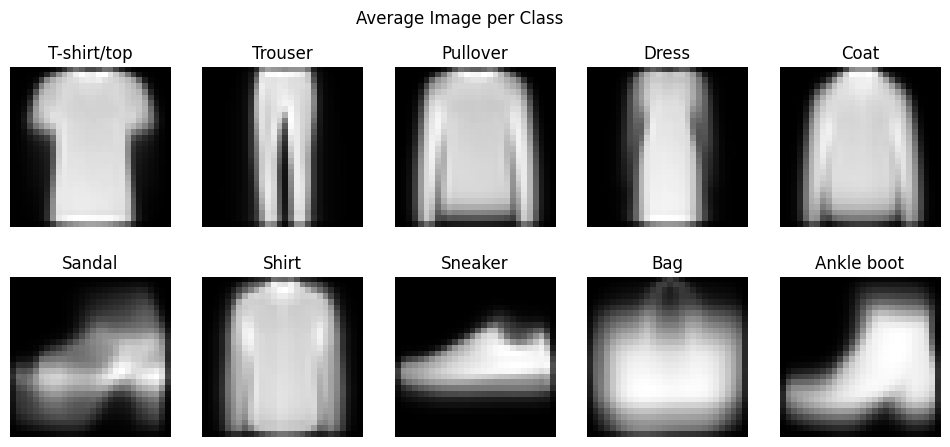

In [7]:
# 8. Optional: Display average image per class (mean pixel intensity)
plt.figure(figsize=(12,5))
for i, class_name in enumerate(class_names):
    class_images = train_images[train_labels == i]
    mean_image = class_images.mean(axis=0)
    plt.subplot(2, 5, i+1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.suptitle("Average Image per Class")
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random

# === Device setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [15]:
# === Hyperparameters ===
latent_dim = 64
batch_size = 128
lr = 1e-3
num_epochs = 100  # Contrastive learning usually needs longer training
margin = 1.0  # For contrastive loss

# === Dataset loading ===
#dataset = load_dataset("zalando-datasets/fashion_mnist")

transform = transforms.Compose([transforms.ToTensor()])

# Custom dataset for Siamese learning (returns pairs)
class SiameseFashionMNIST(Dataset):
    def __init__(self, split='train', transform=None):
        self.data = dataset[split]['image']
        self.labels = dataset[split]['label']
        self.transform = transform

        # Build index for each label to sample positive pairs
        self.label_to_indices = {}
        for idx, label in enumerate(self.labels):
            self.label_to_indices.setdefault(label, []).append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img1 = self.data[index]
        label1 = self.labels[index]

        # Convert to tensor
        if self.transform:
            img1 = self.transform(img1)

        # Decide if pair is positive or negative
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # Pick another image with the same label
            idx2 = index
            while idx2 == index:
                idx2 = random.choice(self.label_to_indices[label1])
        else:
            # Pick an image from a different class
            different_label = label1
            while different_label == label1:
                different_label = random.choice(list(self.label_to_indices.keys()))
            idx2 = random.choice(self.label_to_indices[different_label])

        img2 = self.data[idx2]
        label2 = self.labels[idx2]

        if self.transform:
            img2 = self.transform(img2)

        label = torch.tensor(int(label1 == label2), dtype=torch.float32)  # 1 if same class else 0

        return img1, img2, label



In [16]:
# Prepare dataloaders
train_dataset = SiameseFashionMNIST(split='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# === Model: Encoder for Siamese ===
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return z

model = Encoder(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# === Contrastive Loss function ===
def contrastive_loss(z1, z2, label, margin=1.0):
    euclidean_distance = F.pairwise_distance(z1, z2)
    loss = label * torch.pow(euclidean_distance, 2) + \
           (1 - label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2)
    return loss.mean()




In [17]:
# === Training loop ===
print("Starting contrastive training...")
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0
    for batch_idx, (img1, img2, label) in enumerate(train_loader):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        z1 = model(img1)
        z2 = model(img2)

        loss = contrastive_loss(z1, z2, label, margin)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Contrastive training finished!")



Starting contrastive training...
Epoch [1/100], Loss: 0.0973
Epoch [5/100], Loss: 0.0734
Epoch [10/100], Loss: 0.0679
Epoch [15/100], Loss: 0.0661
Epoch [20/100], Loss: 0.0644
Epoch [25/100], Loss: 0.0628
Epoch [30/100], Loss: 0.0614
Epoch [35/100], Loss: 0.0609
Epoch [40/100], Loss: 0.0593
Epoch [45/100], Loss: 0.0599
Epoch [50/100], Loss: 0.0600
Epoch [55/100], Loss: 0.0588
Epoch [60/100], Loss: 0.0582
Epoch [65/100], Loss: 0.0581
Epoch [70/100], Loss: 0.0581
Epoch [75/100], Loss: 0.0568
Epoch [80/100], Loss: 0.0571
Epoch [85/100], Loss: 0.0570
Epoch [90/100], Loss: 0.0571
Epoch [95/100], Loss: 0.0561
Epoch [100/100], Loss: 0.0559
Contrastive training finished!


In [18]:
# === Extract embeddings for test set ===
# Simple dataset without pairs
class SimpleFashionMNIST(Dataset):
    def __init__(self, split='test', transform=None):
        self.data = dataset[split]['image']
        self.labels = dataset[split]['label']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

test_dataset = SimpleFashionMNIST(split='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_features = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        feats = model(imgs)
        all_features.append(feats.cpu())
        all_labels.append(labels)

features = torch.cat(all_features).numpy()
true_labels = torch.cat(all_labels).numpy()



In [29]:
# === Clustering with GMM ===
print("Clustering embeddings with Gaussian Mixture Model...")
gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=42)
cluster_labels = gmm.fit_predict(features)


Clustering embeddings with Gaussian Mixture Model...


In [30]:
# === Evaluation ===
sil_score = silhouette_score(features, cluster_labels)
db_score = davies_bouldin_score(features, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Index: {db_score:.4f}")



Silhouette Score: 0.5438
Davies-Bouldin Index: 1.4003


Visualizing clusters with t-SNE...


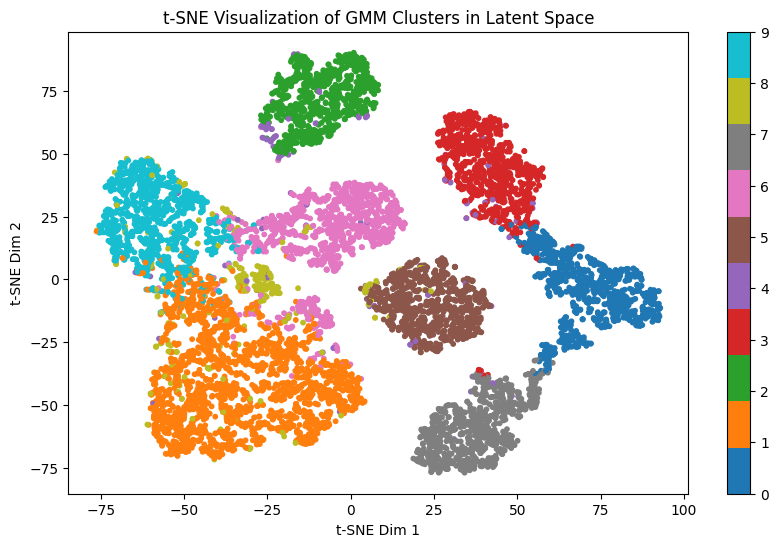

In [21]:
# === Visualization with t-SNE ===
print("Visualizing clusters with t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca')
tsne_results = tsne.fit_transform(features)

plt.figure(figsize=(10,6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of GMM Clusters in Latent Space")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

In [22]:
# === Accuracy calculation ===
from scipy.optimize import linear_sum_assignment

def clustering_accuracy(true_labels, cluster_labels):
    true_labels = np.array(true_labels)
    cluster_labels = np.array(cluster_labels)
    D = max(cluster_labels.max(), true_labels.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(true_labels.size):
        w[cluster_labels[i], true_labels[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return sum([w[row, col] for row, col in zip(row_ind, col_ind)]) / true_labels.size

acc = clustering_accuracy(true_labels, cluster_labels)
print(f"Clustering accuracy: {acc*100:.2f}%")



Clustering accuracy: 75.09%
